<a href="https://colab.research.google.com/github/Monsterp99/LLM-prototype/blob/main/CC_v1_Semantic_Tripe_Analysis_Using_Entity_Sentiment_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Enhanced Semantic Analyzer with Entity Analysis Layer
# This version combines text-based extraction with entity analysis

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import re
from collections import defaultdict, Counter
import warnings
warnings.filterwarnings('ignore')

class EnhancedSemanticAnalyzer:
    def __init__(self):
        """Initialize analyzer with both text patterns and entity analysis"""

        # Same category patterns as before
        self.category_patterns = {
            'services': {
                'entities': ['dental implants', 'implants', 'consultation', 'surgery', 'procedures', 'treatment'],
                'relationship_patterns': [
                    r'\b(dental implants?|implants?|ClearChoice)\s+(provides?|offers?|performs?|specializes?|delivers?)\s+([^.]{1,60})',
                    r'\b(we|our team|ClearChoice)\s+(provides?|offers?|specializes?|performs?)\s+([^.]{1,60})',
                    r'\b(services?|treatments?|procedures?)\s+(include|involves?|consists? of)\s+([^.]{1,60})'
                ],
                'weight': 0.2
            },
            'audience': {
                'entities': ['patients', 'seniors', 'adults', 'people', 'individuals'],
                'relationship_patterns': [
                    r'\b(patients?|seniors?|adults?|people|individuals)\s+(who|with|experiencing|suffering|needing)\s+([^.]{1,60})',
                    r'\b(for\s+patients?|for\s+seniors?|for\s+adults?|for\s+people)\s+(with|who|experiencing)\s+([^.]{1,60})',
                    r'\b(ideal for|perfect for|designed for|helps?)\s+(patients?|seniors?|adults?|people)\s+([^.]{1,60})'
                ],
                'weight': 0.15
            },
            'value_propositions': {
                'entities': ['benefits', 'advantages', 'lifetime', 'permanent', '25 years', 'confidence', 'smile'],
                'relationship_patterns': [
                    r'\b(dental implants?|implants?|treatment)\s+(helps?|improves?|restores?|enhances?|provides?)\s+([^.]{1,60})',
                    r'\b(benefits?|advantages?)\s+(of|include|are)\s+([^.]{1,60})',
                    r'\b(lasts?|last|designed to last|built to last)\s+(a lifetime|lifetime|\d+\s*years?|25\+?\s*years?|forever)\s*([^.]{0,40})',
                    r'\b(permanent|durable|long-lasting)\s+(solution|replacement|restoration|tooth)\s+([^.]{1,60})'
                ],
                'weight': 0.25
            },
            'differentiators': {
                'entities': ['unlike', 'compared to', 'vs', 'better than', 'only', 'unique'],
                'relationship_patterns': [
                    r'\b(unlike|compared to|vs|versus|different from|better than)\s+(dentures?|bridges?|traditional|removable)\s*,?\s*([^.]{1,80})',
                    r'\b(only|exclusively|unique|patented|proprietary)\s+([^.]{1,60})',
                    r'\b(ClearChoice|we|our)\s+(is the only|are the only|exclusively|uniquely)\s+([^.]{1,60})'
                ],
                'weight': 0.2
            },
            'pain_points': {
                'entities': ['problems', 'issues', 'pain', 'discomfort', 'loose', 'missing', 'broken', 'struggle'],
                'relationship_patterns': [
                    r'\b(problems?|issues?|struggles?|difficulties|pain|discomfort|loose|missing|broken|failing)\s+(teeth?|dentures?|implants?)\s*([^.]{1,60})',
                    r'\b(can\'t|cannot|unable to|difficulty|struggle with|suffer from)\s+([^.]{1,60})',
                    r'\b(solves?|addresses?|eliminates?|fixes?)\s+(the problem of|issues with|problems with)\s+([^.]{1,60})'
                ],
                'weight': 0.1
            },
            'quality': {
                'entities': ['quality', 'premium', 'FDA approved', 'certified', 'experienced', 'success rate', 'warranty'],
                'relationship_patterns': [
                    r'\b(quality|premium|high-grade|FDA approved|certified|accredited|experienced)\s+([^.]{1,60})',
                    r'\b(success rate|satisfaction|guarantee|warranty)\s+(of|is|includes?)\s+([^.]{1,60})',
                    r'\b(years? of experience|board certified|specialized|expertise)\s+([^.]{1,60})'
                ],
                'weight': 0.1
            }
        }

        # Noise patterns to filter out
        self.noise_patterns = [
            r'cookies?.*?privacy.*?policy',
            r'javascript.*?enabled',
            r'website.*?functionality',
            r'terms.*?conditions',
            r'privacy.*?policy',
            r'site.*?navigation'
        ]

        # Entity analysis will be loaded separately
        self.entity_data = None

    def load_entity_data(self, entity_file_path):
        """Load and clean entity analysis data"""
        print(f"Loading entity analysis from: {entity_file_path}")

        # Load entity data
        entity_df = pd.read_excel(entity_file_path, sheet_name='Entity Sentiment Data')

        # Clean entity data - remove noise entities
        noise_entities = ['cookies', 'site', 'privacy', 'policy', 'terms', 'website', 'page', 'javascript']
        cleaned_entities = entity_df[~entity_df['Entity'].str.lower().isin(noise_entities)]

        # Filter by minimum salience
        meaningful_entities = cleaned_entities[cleaned_entities['Salience'] > 0.01]

        self.entity_data = meaningful_entities
        print(f"Loaded {len(meaningful_entities)} meaningful entities (filtered from {len(entity_df)} total)")

        return meaningful_entities

    def get_page_entities(self, url):
        """Get entities for a specific page"""
        if self.entity_data is None:
            return pd.DataFrame()

        # Filter entities for this specific URL
        page_entities = self.entity_data[self.entity_data['ID'] == url].copy()
        return page_entities

    def analyze_entity_quality(self, url, page_entities):
        """Analyze entity quality issues for a page"""
        if page_entities.empty:
            return {
                'total_entities': 0,
                'entity_issues': [],
                'entity_quality_score': 0,
                'top_entities': []
            }

        issues = []

        # Check for high-salience noise entities
        high_salience_entities = page_entities[page_entities['Salience'] > 0.1]
        for _, entity in high_salience_entities.iterrows():
            entity_name = entity['Entity'].lower()
            if any(noise in entity_name for noise in ['cookie', 'site', 'privacy', 'policy']):
                issues.append(f"High-salience noise entity: '{entity['Entity']}' (salience: {entity['Salience']:.3f})")

        # Check for entity classification inconsistencies
        entity_names = page_entities['Entity'].str.lower().unique()
        for entity_name in entity_names:
            entity_variations = page_entities[page_entities['Entity'].str.lower() == entity_name]
            if len(entity_variations['Type'].unique()) > 1:
                types = ', '.join(entity_variations['Type'].unique())
                issues.append(f"Inconsistent classification for '{entity_name}': {types}")

        # Check for business entities classified as "OTHER"
        business_terms = ['clearchoice', 'dental implant', 'implant center']
        other_entities = page_entities[page_entities['Type'] == 'OTHER']
        for _, entity in other_entities.iterrows():
            entity_name = entity['Entity'].lower()
            if any(term in entity_name for term in business_terms) and entity['Salience'] > 0.05:
                issues.append(f"Business entity classified as OTHER: '{entity['Entity']}' (should be ORGANIZATION)")

        # Calculate entity quality score
        total_entities = len(page_entities)
        meaningful_entities = len(page_entities[page_entities['Salience'] > 0.02])
        entity_quality_score = meaningful_entities / total_entities if total_entities > 0 else 0

        # Get top entities
        top_entities = page_entities.nlargest(5, 'Salience')[['Entity', 'Type', 'Salience', 'Sentiment Score']].to_dict('records')

        return {
            'total_entities': total_entities,
            'meaningful_entities': meaningful_entities,
            'entity_issues': issues,
            'entity_quality_score': entity_quality_score,
            'top_entities': top_entities
        }

    def enhance_triple_confidence_with_entities(self, triple, page_entities):
        """Use entity analysis to enhance triple confidence scores"""
        if page_entities.empty:
            return triple['confidence']  # Return original confidence if no entity data

        enhanced_confidence = triple['confidence']

        # Look for subject entity in entity analysis
        subject_entities = page_entities[page_entities['Entity'].str.lower().str.contains(triple['subject'].lower(), na=False)]
        if not subject_entities.empty:
            # Boost confidence based on entity salience
            max_salience = subject_entities['Salience'].max()
            salience_boost = min(0.2, max_salience * 2)  # Max boost of 0.2
            enhanced_confidence += salience_boost

            # Check sentiment alignment
            avg_sentiment = subject_entities['Sentiment Score'].mean()
            if triple['category'] in ['value_propositions', 'quality', 'services'] and avg_sentiment > 0:
                enhanced_confidence += 0.1  # Positive sentiment boost for positive categories
            elif triple['category'] == 'pain_points' and avg_sentiment < 0:
                enhanced_confidence += 0.1  # Negative sentiment appropriate for pain points

        # Look for object entity
        object_entities = page_entities[page_entities['Entity'].str.lower().str.contains(triple['object'].lower(), na=False)]
        if not object_entities.empty:
            max_salience = object_entities['Salience'].max()
            salience_boost = min(0.15, max_salience * 1.5)
            enhanced_confidence += salience_boost

        return min(1.0, enhanced_confidence)

    def clean_content(self, content):
        """Remove noise from content to focus on semantic content"""
        if not content:
            return ""

        # Remove cookie notices and privacy policy text
        cleaned = content
        for pattern in self.noise_patterns:
            cleaned = re.sub(pattern, '', cleaned, flags=re.IGNORECASE)

        # Remove excessive whitespace
        cleaned = re.sub(r'\s+', ' ', cleaned).strip()

        # Remove common UI elements
        ui_patterns = [
            r'These cookies.*?understand how users interact with[^.]*\.',
            r'We use cookies.*?improve.*?performance[^.]*\.',
            r'By clicking.*?accept.*?cookies[^.]*\.',
        ]

        for pattern in ui_patterns:
            cleaned = re.sub(pattern, '', cleaned, flags=re.IGNORECASE | re.DOTALL)

        return cleaned

    def extract_category_triples(self, content, category_name, page_entities=None):
        """Extract semantic triples for a specific category"""
        if not content:
            return []

        category_config = self.category_patterns[category_name]
        triples = []

        # Extract triples using relationship patterns
        for pattern in category_config['relationship_patterns']:
            matches = re.finditer(pattern, content, re.IGNORECASE)
            for match in matches:
                groups = match.groups()
                if len(groups) >= 3:
                    subject = groups[0].strip()
                    predicate = groups[1].strip() if len(groups) > 1 else 'relates_to'
                    obj = groups[2].strip()

                    # Clean up the extracted parts
                    subject = re.sub(r'\s+', ' ', subject)
                    obj = re.sub(r'\s+', ' ', obj)

                    # Calculate base confidence
                    base_confidence = self._calculate_triple_confidence(subject, predicate, obj, category_name)

                    triple = {
                        'category': category_name,
                        'subject': subject,
                        'predicate': predicate,
                        'object': obj,
                        'confidence': base_confidence,
                        'pattern_match': match.group(0)[:100] + '...' if len(match.group(0)) > 100 else match.group(0)
                    }

                    # Enhance confidence with entity analysis if available
                    if page_entities is not None and not page_entities.empty:
                        triple['confidence'] = self.enhance_triple_confidence_with_entities(triple, page_entities)
                        triple['entity_enhanced'] = True
                    else:
                        triple['entity_enhanced'] = False

                    triples.append(triple)

        return triples

    def _calculate_triple_confidence(self, subject, predicate, obj, category):
        """Calculate base confidence score for a semantic triple"""
        confidence = 0.5  # Base confidence

        # Bonus for category-specific entities
        category_entities = self.category_patterns[category]['entities']
        for entity in category_entities:
            if entity.lower() in subject.lower() or entity.lower() in obj.lower():
                confidence += 0.2
                break

        # Bonus for specific predicates
        strong_predicates = ['provides', 'offers', 'helps', 'solves', 'eliminates', 'lasts', 'includes']
        if predicate.lower() in strong_predicates:
            confidence += 0.15

        # Bonus for business-relevant subjects
        if any(term in subject.lower() for term in ['dental implants', 'clearchoice', 'implants', 'treatment']):
            confidence += 0.15

        # Penalty for very long or very short objects
        if len(obj) < 10 or len(obj) > 80:
            confidence -= 0.1

        return min(1.0, max(0.1, confidence))

    def analyze_page_comprehensively(self, url, content):
        """Comprehensive analysis of a single page with entity layering"""

        # Clean the content
        cleaned_content = self.clean_content(content)

        # Get entity data for this page
        page_entities = self.get_page_entities(url)

        # Analyze entity quality
        entity_analysis = self.analyze_entity_quality(url, page_entities)

        # Extract triples for each category (with entity enhancement)
        all_triples = []
        category_scores = {}

        for category_name in self.category_patterns.keys():
            triples = self.extract_category_triples(cleaned_content, category_name, page_entities)
            all_triples.extend(triples)

            # Calculate category score based on triples found
            high_conf_triples = [t for t in triples if t['confidence'] > 0.6]
            category_scores[category_name] = {
                'total_triples': len(triples),
                'high_confidence_triples': len(high_conf_triples),
                'avg_confidence': np.mean([t['confidence'] for t in triples]) if triples else 0,
                'score': min(1.0, len(high_conf_triples) / 3.0),
                'entity_enhanced_triples': len([t for t in triples if t.get('entity_enhanced', False)])
            }

        # Calculate overall page metrics
        word_count = len(cleaned_content.split())

        metrics = {
            'url': url,
            'url_short': url.split('/')[-2] if len(url.split('/')) > 3 else url.split('/')[-1],
            'original_content_length': len(content),
            'cleaned_content_length': len(cleaned_content),
            'noise_ratio': 1 - (len(cleaned_content) / len(content)) if content else 0,
            'word_count': word_count,
            'total_triples': len(all_triples),
            'high_confidence_triples': len([t for t in all_triples if t['confidence'] > 0.6]),
            'entity_enhanced_triples': len([t for t in all_triples if t.get('entity_enhanced', False)]),
            'category_coverage': len([cat for cat, scores in category_scores.items() if scores['total_triples'] > 0]),
            'category_scores': category_scores,
            'semantic_triples': all_triples,
            'entity_analysis': entity_analysis
        }

        # Calculate composite semantic quality score
        metrics['semantic_quality_score'] = self._calculate_semantic_quality_score(category_scores, entity_analysis)

        return metrics

    def _calculate_semantic_quality_score(self, category_scores, entity_analysis):
        """Calculate weighted semantic quality score with entity quality factor"""
        base_score = 0

        for category, scores in category_scores.items():
            weight = self.category_patterns[category]['weight']
            category_score = scores['score']
            base_score += weight * category_score

        # Factor in entity quality (10% of total score)
        entity_quality_factor = entity_analysis['entity_quality_score'] * 0.1

        total_score = base_score + entity_quality_factor
        return min(1.0, total_score)

def analyze_with_entity_layer(text_file, entity_file=None):
    """Main function to analyze content with optional entity analysis layer"""

    analyzer = EnhancedSemanticAnalyzer()

    # Load entity data if provided
    if entity_file:
        analyzer.load_entity_data(entity_file)
        print("✅ Entity analysis layer loaded")
    else:
        print("📝 Running text-only analysis (no entity layer)")

    # Load text data
    print(f"Loading text data from: {text_file}")
    text_df = pd.read_excel(text_file)
    print(f"Loaded {len(text_df)} pages")

    results = []

    print("Analyzing content...")

    for index, row in text_df.iterrows():
        url = row['URL']
        content = row['content']

        page_name = url.split('/')[-2] if len(url.split('/')) > 3 else url.split('/')[-1]
        print(f"Analyzing page {index+1}/{len(text_df)}: {page_name}")

        # Analyze this page
        analysis = analyzer.analyze_page_comprehensively(url, content)
        results.append(analysis)

    # Convert to DataFrame
    results_df = pd.DataFrame([
        {
            'url_short': r['url_short'],
            'semantic_quality_score': r['semantic_quality_score'],
            'total_triples': r['total_triples'],
            'high_confidence_triples': r['high_confidence_triples'],
            'entity_enhanced_triples': r['entity_enhanced_triples'],
            'category_coverage': r['category_coverage'],
            'noise_ratio': r['noise_ratio'],
            'entity_quality_score': r['entity_analysis']['entity_quality_score'],
            'entity_issues_count': len(r['entity_analysis']['entity_issues']),
            'services_score': r['category_scores']['services']['score'],
            'value_props_score': r['category_scores']['value_propositions']['score'],
            'differentiators_score': r['category_scores']['differentiators']['score'],
            'audience_score': r['category_scores']['audience']['score'],
            'pain_points_score': r['category_scores']['pain_points']['score'],
            'quality_score': r['category_scores']['quality']['score']
        }
        for r in results
    ])

    print("\n=== ANALYSIS COMPLETE ===")
    print(f"Average semantic quality score: {results_df['semantic_quality_score'].mean():.3f}")
    if entity_file:
        print(f"Average entity quality score: {results_df['entity_quality_score'].mean():.3f}")
        print(f"Total entity-enhanced triples: {results_df['entity_enhanced_triples'].sum()}")

    return results, results_df, analyzer

def show_enhanced_page_details(results, page_identifier):
    """Show detailed analysis including entity insights"""

    page_result = None
    for result in results:
        if page_identifier in result['url_short']:
            page_result = result
            break

    if not page_result:
        print(f"Page '{page_identifier}' not found")
        return

    print(f"=== ENHANCED ANALYSIS: {page_result['url_short']} ===")
    print(f"Semantic Quality Score: {page_result['semantic_quality_score']:.3f}")
    print(f"Total Semantic Triples: {page_result['total_triples']}")
    print(f"High Confidence Triples: {page_result['high_confidence_triples']}")
    print(f"Entity-Enhanced Triples: {page_result['entity_enhanced_triples']}")
    print(f"Category Coverage: {page_result['category_coverage']}/6")
    print()

    # Entity analysis section
    entity_analysis = page_result['entity_analysis']
    print("=== ENTITY ANALYSIS ===")
    print(f"Total Entities: {entity_analysis['total_entities']}")
    print(f"Meaningful Entities: {entity_analysis['meaningful_entities']}")
    print(f"Entity Quality Score: {entity_analysis['entity_quality_score']:.3f}")

    if entity_analysis['entity_issues']:
        print("Entity Issues Found:")
        for issue in entity_analysis['entity_issues']:
            print(f"  ⚠️  {issue}")
    else:
        print("✅ No entity quality issues detected")

    if entity_analysis['top_entities']:
        print("\nTop Entities:")
        for entity in entity_analysis['top_entities']:
            print(f"  • {entity['Entity']} ({entity['Type']}): salience={entity['Salience']:.3f}, sentiment={entity['Sentiment Score']:.2f}")

    print("\n=== SEMANTIC TRIPLES (Entity-Enhanced) ===")
    for i, triple in enumerate(page_result['semantic_triples'][:10]):
        enhancement = "🔥" if triple.get('entity_enhanced', False) else "📝"
        print(f"{i+1:2d}. {enhancement} [{triple['category'].upper()}] {triple['subject']} → {triple['predicate']} → {triple['object']}")
        print(f"    Confidence: {triple['confidence']:.2f}")

print("✅ Enhanced analyzer loaded successfully!")
print("\nTo run with entity analysis layer:")
print("results, results_df, analyzer = analyze_with_entity_layer('text_file.xlsx', 'entity_file.xlsx')")
print("\nTo run text-only analysis:")
print("results, results_df, analyzer = analyze_with_entity_layer('text_file.xlsx')")

✅ Enhanced analyzer loaded successfully!

To run with entity analysis layer:
results, results_df, analyzer = analyze_with_entity_layer('text_file.xlsx', 'entity_file.xlsx')

To run text-only analysis:
results, results_df, analyzer = analyze_with_entity_layer('text_file.xlsx')


In [ ]:
results, results_df, analyzer = analyze_with_entity_layer(
    '(testing) CC-TAG URL_Text Extraction.xlsx',
    'CC_TAG Entity Analysis w. Google NLP.xlsx'
)

Loading entity analysis from: CC_TAG Entity Analysis w. Google NLP.xlsx
Loaded 219 meaningful entities (filtered from 1798 total)
✅ Entity analysis layer loaded
Loading text data from: (testing) CC-TAG URL_Text Extraction.xlsx
Loaded 10 pages
Analyzing content...
Analyzing page 1/10: patient-resources
Analyzing page 2/10: how-to-address-loose-dental-implants
Analyzing page 3/10: dental-implant-healing-importance
Analyzing page 4/10: what-are-dental-implants
Analyzing page 5/10: dentures-vs-implants
Analyzing page 6/10: dental-implant-insurance
Analyzing page 7/10: cost-of-dental-implants
Analyzing page 8/10: affordable-dental-implants
Analyzing page 9/10: 1629434410
Analyzing page 10/10: 1437500592

=== ANALYSIS COMPLETE ===
Average semantic quality score: 0.230
Average entity quality score: 0.415
Total entity-enhanced triples: 49


In [ ]:
# After running analysis, get pages needing optimization:
poor_pages = results_df[results_df['semantic_quality_score'] < 0.3]
print("Pages needing immediate optimization:")
for _, page in poor_pages.iterrows():
    print(f"❌ {page['url_short']}: Score {page['semantic_quality_score']:.3f}")

Pages needing immediate optimization:
❌ patient-resources: Score 0.130
❌ how-to-address-loose-dental-implants: Score 0.158
❌ dentures-vs-implants: Score 0.193
❌ dental-implant-insurance: Score 0.107
❌ cost-of-dental-implants: Score 0.017
❌ affordable-dental-implants: Score 0.224
❌ 1629434410: Score 0.193
❌ 1437500592: Score 0.176


In [ ]:
# Pages missing key categories
missing_services = results_df[results_df['services_score'] == 0]
missing_differentiators = results_df[results_df['differentiators_score'] == 0]
weak_value_props = results_df[results_df['value_props_score'] < 0.2]

In [ ]:
show_enhanced_page_details(results, 'dentures-vs-implants')
# Shows exactly what's missing and what to add

=== ENHANCED ANALYSIS: dentures-vs-implants ===
Semantic Quality Score: 0.193
Total Semantic Triples: 4
High Confidence Triples: 2
Entity-Enhanced Triples: 4
Category Coverage: 2/6

=== ENTITY ANALYSIS ===
Total Entities: 7
Meaningful Entities: 3
Entity Quality Score: 0.429
Entity Issues Found:
  ⚠️  Inconsistent classification for 'implants': CONSUMER_GOOD, OTHER

Top Entities:
  • Implants (CONSUMER_GOOD): salience=0.309, sentiment=0.30
  • dental implants (OTHER): salience=0.025, sentiment=0.30
  • implants (OTHER): salience=0.020, sentiment=0.80
  • Dentures (OTHER): salience=0.019, sentiment=0.00
  • smile (OTHER): salience=0.017, sentiment=0.70

=== SEMANTIC TRIPLES (Entity-Enhanced) ===
 1. 🔥 [SERVICES] Dental implants → provide → you with a comfortable and confident smile that can support
    Confidence: 1.00
 2. 🔥 [VALUE_PROPOSITIONS] Dental implants → provide → you with a comfortable and confident smile that can support
    Confidence: 1.00
 3. 🔥 [VALUE_PROPOSITIONS] last → 2

In [ ]:
# Enhanced Semantic Analyzer with Custom Intent Categories
# Updated with the same 9-category intent system from MUVERA

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import re
from collections import defaultdict, Counter
import warnings
warnings.filterwarnings('ignore')

class EnhancedSemanticAnalyzer:
    def __init__(self):
        """Initialize analyzer with custom intent categories and entity analysis"""

        # Updated category patterns with custom dental implant intent categories
        self.category_patterns = {
            'comparative_analysis_final_decision': {
                'entities': ['compared to', 'vs', 'versus', 'better than', 'pros and cons', 'comparison', 'choose', 'decide', 'final decision'],
                'relationship_patterns': [
                    r'\b(dental implants?|implants?|treatment)\s+(compared to|vs|versus|better than)\s+([^.]{1,80})',
                    r'\b(pros and cons|advantages and disadvantages)\s+(of|for)\s+([^.]{1,60})',
                    r'\b(choose|choosing|decide|decision)\s+(between|dental implants?|implants?)\s+([^.]{1,60})',
                    r'\b(final decision|best option|right choice)\s+(for|dental implants?|implants?)\s*([^.]{1,60})',
                    r'\b(functionality comparison|aesthetic differences|longevity comparison)\s+([^.]{1,60})'
                ],
                'weight': 0.143
            },
            'core_need_assessment': {
                'entities': ['do I need', 'am I candidate', 'signs you need', 'missing teeth', 'tooth replacement', 'dental problems'],
                'relationship_patterns': [
                    r'\b(do I need|am I candidate|signs you need)\s+(dental implants?|implants?|treatment)\s*([^.]{1,60})',
                    r'\b(missing teeth|tooth replacement|dental problems)\s+(solutions?|options?|treatment)\s*([^.]{1,60})',
                    r'\b(are dental implants worth it|benefits of dental implants)\s*([^.]{1,60})',
                    r'\b(candidacy|candidates?|eligible)\s+(for|dental implants?|implants?)\s*([^.]{1,60})',
                    r'\b(consequences|risks)\s+(of not replacing|missing teeth|tooth loss)\s*([^.]{1,60})'
                ],
                'weight': 0.012
            },
            'cost_financing_considerations': {
                'entities': ['cost', 'price', 'financing', 'payment plan', 'insurance', 'affordable', 'budget', 'how much'],
                'relationship_patterns': [
                    r'\b(cost|price|financing|payment)\s+(of|for|dental implants?|implants?)\s*([^.]{1,60})',
                    r'\b(insurance|affordable|budget|how much)\s+(dental implants?|implants?|coverage)\s*([^.]{1,60})',
                    r'\b(payment plans?|financing options?)\s+(for|available)\s*([^.]{1,60})',
                    r'\b(hidden costs|total cost|average cost)\s+(dental implants?|implants?)\s*([^.]{1,60})',
                    r'\b(hsa|fsa|carecredit)\s+(dental implants?|implants?|funds)\s*([^.]{1,60})'
                ],
                'weight': 0.093
            },
            'location_considerations': {
                'entities': ['near me', 'location', 'find dentist', 'in my area', 'local', 'appointments', 'best dentist'],
                'relationship_patterns': [
                    r'\b(near me|in my area|local|find dentist)\s+(dental implants?|implants?|dentist)\s*([^.]{1,60})',
                    r'\b(best|experienced)\s+(dentist|oral surgeon|implant specialist)\s+(near me|in my area|local)\s*([^.]{1,60})',
                    r'\b(location|appointments|technology)\s+(dental implant centers?|implant centers?)\s*([^.]{1,60})',
                    r'\b(private practice|corporate|local follow-up)\s+(dental implants?|implants?)\s*([^.]{1,60})',
                    r'\b(success rates|reviews|comparing)\s+(providers?|dentists?|oral surgeons?)\s*([^.]{1,60})'
                ],
                'weight': 0.55
            },
            'pre_procedure_evaluation_eligibility': {
                'entities': ['consultation', 'eligible', 'qualify', 'bone density', 'medical history', 'evaluation'],
                'relationship_patterns': [
                    r'\b(consultation|eligible|qualify|candidacy)\s+(for|dental implants?|implants?)\s*([^.]{1,60})',
                    r'\b(bone density|medical history|evaluation|assessment)\s+(dental implants?|implants?)\s*([^.]{1,60})',
                    r'\b(smoking|medical conditions|age requirements)\s+(dental implants?|implants?|affect)\s*([^.]{1,60})',
                    r'\b(pre-surgical|imaging|ct scan|x-rays)\s+(dental implants?|implants?)\s*([^.]{1,60})',
                    r'\b(disqualification|postponed|requirements)\s+(dental implants?|implants?|surgery)\s*([^.]{1,60})'
                ],
                'weight': 0.111
            },
            'procedure_clinical_information': {
                'entities': ['how it works', 'surgery', 'procedure', 'osseointegration', 'clinical details', 'implant procedure'],
                'relationship_patterns': [
                    r'\b(how it works|surgery|procedure|osseointegration)\s+(dental implants?|implants?)\s*([^.]{1,60})',
                    r'\b(clinical details|procedure steps|surgery expectations)\s+(dental implants?|implants?)\s*([^.]{1,60})',
                    r'\b(bone grafting|sedation|anesthesia)\s+(dental implants?|implants?|surgery)\s*([^.]{1,60})',
                    r'\b(immediate load|traditional|staged)\s+(dental implants?|implants?)\s*([^.]{1,60})',
                    r'\b(3d imaging|digital technology|materials)\s+(dental implants?|implants?)\s*([^.]{1,60})'
                ],
                'weight': 0.078
            },
            'recovery_longevity_aftercare': {
                'entities': ['recovery', 'healing', 'aftercare', 'how long', 'longevity', 'maintenance'],
                'relationship_patterns': [
                    r'\b(recovery|healing|aftercare|how long)\s+(dental implants?|implants?)\s*([^.]{1,60})',
                    r'\b(longevity|lifespan|maintenance|care)\s+(dental implants?|implants?)\s*([^.]{1,60})',
                    r'\b(pain management|complications|follow-up)\s+(dental implants?|implants?|surgery)\s*([^.]{1,60})',
                    r'\b(first 24 hours|recovery timeline|healing timeline)\s+(dental implants?|implants?)\s*([^.]{1,60})',
                    r'\b(annual checkups|long-term care|extend)\s+(dental implants?|implants?)\s*([^.]{1,60})'
                ],
                'weight': 0.008
            },
            'reviews_provider_assessment': {
                'entities': ['experience', 'doctor credentials', 'dentist qualifications', 'specialist', 'who'],
                'relationship_patterns': [
                    r'\b(experience|doctor credentials|dentist qualifications)\s+(dental implants?|implants?|oral surgeon)\s*([^.]{1,60})',
                    r'\b(specialist|who|comparing|research)\s+(dental implant providers?|oral surgeons?|dentists?)\s*([^.]{1,60})',
                    r'\b(second opinion|credentials|communication)\s+(dental implants?|implants?|provider)\s*([^.]{1,60})',
                    r'\b(corporate vs private|provider experience|red flags)\s+(dental implants?|implants?)\s*([^.]{1,60})',
                    r'\b(poor|warning signs|research tips)\s+(dental implant providers?|oral surgeons?)\s*([^.]{1,60})'
                ],
                'weight': 0.108
            },
            'reviews_testimonials': {
                'entities': ['reviews', 'testimonials', 'before and after', 'patient experiences', 'success stories'],
                'relationship_patterns': [
                    r'\b(reviews|testimonials|before and after)\s+(dental implants?|implants?|patients?)\s*([^.]{1,60})',
                    r'\b(patient experiences|success stories|patient feedback)\s+(dental implants?|implants?)\s*([^.]{1,60})',
                    r'\b(patient advice|patient concerns|patient questions)\s+(dental implants?|implants?)\s*([^.]{1,60})',
                    r'\b(positive experiences|life change|smile improvements)\s+(dental implants?|implants?)\s*([^.]{1,60})',
                    r'\b(common themes|interpreting reviews|reading reviews)\s+(dental implants?|implants?)\s*([^.]{1,60})'
                ],
                'weight': 0.007
            }
        }

        # Noise patterns to filter out
        self.noise_patterns = [
            r'cookies?.*?privacy.*?policy',
            r'javascript.*?enabled',
            r'website.*?functionality',
            r'terms.*?conditions',
            r'privacy.*?policy',
            r'site.*?navigation'
        ]

        # Entity analysis will be loaded separately
        self.entity_data = None

    def load_entity_data(self, entity_file_path):
        """Load and clean entity analysis data"""
        print(f"Loading entity analysis from: {entity_file_path}")

        # Load entity data
        entity_df = pd.read_excel(entity_file_path, sheet_name='Entity Sentiment Data')

        # Clean entity data - remove noise entities
        noise_entities = ['cookies', 'site', 'privacy', 'policy', 'terms', 'website', 'page', 'javascript']
        cleaned_entities = entity_df[~entity_df['Entity'].str.lower().isin(noise_entities)]

        # Filter by minimum salience
        meaningful_entities = cleaned_entities[cleaned_entities['Salience'] > 0.01]

        self.entity_data = meaningful_entities
        print(f"Loaded {len(meaningful_entities)} meaningful entities (filtered from {len(entity_df)} total)")

        return meaningful_entities

    def get_page_entities(self, url):
        """Get entities for a specific page"""
        if self.entity_data is None:
            return pd.DataFrame()

        # Filter entities for this specific URL
        page_entities = self.entity_data[self.entity_data['ID'] == url].copy()
        return page_entities

    def analyze_entity_quality(self, url, page_entities):
        """Analyze entity quality issues for a page"""
        if page_entities.empty:
            return {
                'total_entities': 0,
                'entity_issues': [],
                'entity_quality_score': 0,
                'top_entities': []
            }

        issues = []

        # Check for high-salience noise entities
        high_salience_entities = page_entities[page_entities['Salience'] > 0.1]
        for _, entity in high_salience_entities.iterrows():
            entity_name = entity['Entity'].lower()
            if any(noise in entity_name for noise in ['cookie', 'site', 'privacy', 'policy']):
                issues.append(f"High-salience noise entity: '{entity['Entity']}' (salience: {entity['Salience']:.3f})")

        # Check for entity classification inconsistencies
        entity_names = page_entities['Entity'].str.lower().unique()
        for entity_name in entity_names:
            entity_variations = page_entities[page_entities['Entity'].str.lower() == entity_name]
            if len(entity_variations['Type'].unique()) > 1:
                types = ', '.join(entity_variations['Type'].unique())
                issues.append(f"Inconsistent classification for '{entity_name}': {types}")

        # Check for business entities classified as "OTHER"
        business_terms = ['clearchoice', 'dental implant', 'implant center']
        other_entities = page_entities[page_entities['Type'] == 'OTHER']
        for _, entity in other_entities.iterrows():
            entity_name = entity['Entity'].lower()
            if any(term in entity_name for term in business_terms) and entity['Salience'] > 0.05:
                issues.append(f"Business entity classified as OTHER: '{entity['Entity']}' (should be ORGANIZATION)")

        # Calculate entity quality score
        total_entities = len(page_entities)
        meaningful_entities = len(page_entities[page_entities['Salience'] > 0.02])
        entity_quality_score = meaningful_entities / total_entities if total_entities > 0 else 0

        # Get top entities
        top_entities = page_entities.nlargest(5, 'Salience')[['Entity', 'Type', 'Salience', 'Sentiment Score']].to_dict('records')

        return {
            'total_entities': total_entities,
            'meaningful_entities': meaningful_entities,
            'entity_issues': issues,
            'entity_quality_score': entity_quality_score,
            'top_entities': top_entities
        }

    def enhance_triple_confidence_with_entities(self, triple, page_entities):
        """Use entity analysis to enhance triple confidence scores"""
        if page_entities.empty:
            return triple['confidence']  # Return original confidence if no entity data

        enhanced_confidence = triple['confidence']

        # Look for subject entity in entity analysis
        subject_entities = page_entities[page_entities['Entity'].str.lower().str.contains(triple['subject'].lower(), na=False)]
        if not subject_entities.empty:
            # Boost confidence based on entity salience
            max_salience = subject_entities['Salience'].max()
            salience_boost = min(0.2, max_salience * 2)  # Max boost of 0.2
            enhanced_confidence += salience_boost

            # Check sentiment alignment
            avg_sentiment = subject_entities['Sentiment Score'].mean()
            if triple['category'] in ['comparative_analysis_final_decision', 'cost_financing_considerations', 'location_considerations'] and avg_sentiment > 0:
                enhanced_confidence += 0.1  # Positive sentiment boost for high-value categories
            elif triple['category'] in ['core_need_assessment', 'reviews_testimonials'] and avg_sentiment < 0:
                enhanced_confidence += 0.1  # Negative sentiment appropriate for need assessment

        # Look for object entity
        object_entities = page_entities[page_entities['Entity'].str.lower().str.contains(triple['object'].lower(), na=False)]
        if not object_entities.empty:
            max_salience = object_entities['Salience'].max()
            salience_boost = min(0.15, max_salience * 1.5)
            enhanced_confidence += salience_boost

        return min(1.0, enhanced_confidence)

    def clean_content(self, content):
        """Remove noise from content to focus on semantic content"""
        if not content:
            return ""

        # Remove cookie notices and privacy policy text
        cleaned = content
        for pattern in self.noise_patterns:
            cleaned = re.sub(pattern, '', cleaned, flags=re.IGNORECASE)

        # Remove excessive whitespace
        cleaned = re.sub(r'\s+', ' ', cleaned).strip()

        # Remove common UI elements
        ui_patterns = [
            r'These cookies.*?understand how users interact with[^.]*\.',
            r'We use cookies.*?improve.*?performance[^.]*\.',
            r'By clicking.*?accept.*?cookies[^.]*\.',
        ]

        for pattern in ui_patterns:
            cleaned = re.sub(pattern, '', cleaned, flags=re.IGNORECASE | re.DOTALL)

        return cleaned

    def extract_category_triples(self, content, category_name, page_entities=None):
        """Extract semantic triples for a specific category"""
        if not content:
            return []

        category_config = self.category_patterns[category_name]
        triples = []

        # Extract triples using relationship patterns
        for pattern in category_config['relationship_patterns']:
            matches = re.finditer(pattern, content, re.IGNORECASE)
            for match in matches:
                groups = match.groups()
                if len(groups) >= 3:
                    subject = groups[0].strip()
                    predicate = groups[1].strip() if len(groups) > 1 else 'relates_to'
                    obj = groups[2].strip()

                    # Clean up the extracted parts
                    subject = re.sub(r'\s+', ' ', subject)
                    obj = re.sub(r'\s+', ' ', obj)

                    # Calculate base confidence
                    base_confidence = self._calculate_triple_confidence(subject, predicate, obj, category_name)

                    triple = {
                        'category': category_name,
                        'subject': subject,
                        'predicate': predicate,
                        'object': obj,
                        'confidence': base_confidence,
                        'pattern_match': match.group(0)[:100] + '...' if len(match.group(0)) > 100 else match.group(0)
                    }

                    # Enhance confidence with entity analysis if available
                    if page_entities is not None and not page_entities.empty:
                        triple['confidence'] = self.enhance_triple_confidence_with_entities(triple, page_entities)
                        triple['entity_enhanced'] = True
                    else:
                        triple['entity_enhanced'] = False

                    triples.append(triple)

        return triples

    def _calculate_triple_confidence(self, subject, predicate, obj, category):
        """Calculate base confidence score for a semantic triple"""
        confidence = 0.5  # Base confidence

        # Bonus for category-specific entities
        category_entities = self.category_patterns[category]['entities']
        for entity in category_entities:
            if entity.lower() in subject.lower() or entity.lower() in obj.lower():
                confidence += 0.2
                break

        # Bonus for specific predicates based on category
        if category == 'comparative_analysis_final_decision':
            strong_predicates = ['compared to', 'vs', 'versus', 'better than', 'choose', 'decide']
        elif category == 'cost_financing_considerations':
            strong_predicates = ['costs', 'financing', 'payment', 'insurance', 'affordable']
        elif category == 'location_considerations':
            strong_predicates = ['near', 'local', 'find', 'location', 'appointments']
        else:
            strong_predicates = ['provides', 'offers', 'helps', 'solves', 'eliminates', 'includes']

        if any(pred in predicate.lower() for pred in strong_predicates):
            confidence += 0.15

        # Bonus for business-relevant subjects
        if any(term in subject.lower() for term in ['dental implants', 'clearchoice', 'implants', 'treatment', 'oral surgery']):
            confidence += 0.15

        # Category-specific confidence adjustments based on business weights
        category_weight = self.category_patterns[category]['weight']
        if category_weight > 0.1:  # High-value categories
            confidence += 0.1
        elif category_weight < 0.02:  # Low-value categories
            confidence -= 0.05

        # Penalty for very long or very short objects
        if len(obj) < 10 or len(obj) > 80:
            confidence -= 0.1

        return min(1.0, max(0.1, confidence))

    def analyze_page_comprehensively(self, url, content):
        """Comprehensive analysis of a single page with entity layering"""

        # Clean the content
        cleaned_content = self.clean_content(content)

        # Get entity data for this page
        page_entities = self.get_page_entities(url)

        # Analyze entity quality
        entity_analysis = self.analyze_entity_quality(url, page_entities)

        # Extract triples for each category (with entity enhancement)
        all_triples = []
        category_scores = {}

        for category_name in self.category_patterns.keys():
            triples = self.extract_category_triples(cleaned_content, category_name, page_entities)
            all_triples.extend(triples)

            # Calculate category score based on triples found and business weight
            high_conf_triples = [t for t in triples if t['confidence'] > 0.6]
            business_weight = self.category_patterns[category_name]['weight']

            category_scores[category_name] = {
                'total_triples': len(triples),
                'high_confidence_triples': len(high_conf_triples),
                'avg_confidence': np.mean([t['confidence'] for t in triples]) if triples else 0,
                'score': min(1.0, len(high_conf_triples) / 3.0) * business_weight,  # Weight by business value
                'business_weight': business_weight,
                'entity_enhanced_triples': len([t for t in triples if t.get('entity_enhanced', False)])
            }

        # Calculate overall page metrics
        word_count = len(cleaned_content.split())

        metrics = {
            'url': url,
            'url_short': url.split('/')[-2] if len(url.split('/')) > 3 else url.split('/')[-1],
            'original_content_length': len(content),
            'cleaned_content_length': len(cleaned_content),
            'noise_ratio': 1 - (len(cleaned_content) / len(content)) if content else 0,
            'word_count': word_count,
            'total_triples': len(all_triples),
            'high_confidence_triples': len([t for t in all_triples if t['confidence'] > 0.6]),
            'entity_enhanced_triples': len([t for t in all_triples if t.get('entity_enhanced', False)]),
            'category_coverage': len([cat for cat, scores in category_scores.items() if scores['total_triples'] > 0]),
            'category_scores': category_scores,
            'semantic_triples': all_triples,
            'entity_analysis': entity_analysis
        }

        # Calculate composite semantic quality score
        metrics['semantic_quality_score'] = self._calculate_semantic_quality_score(category_scores, entity_analysis)

        return metrics

    def _calculate_semantic_quality_score(self, category_scores, entity_analysis):
        """Calculate weighted semantic quality score with business weights and entity quality factor"""
        base_score = 0

        # Sum all category scores (already weighted by business value)
        for category, scores in category_scores.items():
            base_score += scores['score']

        # Factor in entity quality (10% of total score)
        entity_quality_factor = entity_analysis['entity_quality_score'] * 0.1

        total_score = base_score + entity_quality_factor
        return min(1.0, total_score)

def analyze_with_custom_intent_categories(text_file, entity_file=None):
    """Main function to analyze content with custom intent categories and optional entity analysis layer"""

    analyzer = EnhancedSemanticAnalyzer()

    # Load entity data if provided
    if entity_file:
        analyzer.load_entity_data(entity_file)
        print("✅ Entity analysis layer loaded")
    else:
        print("📝 Running text-only analysis (no entity layer)")

    # Load text data
    print(f"Loading text data from: {text_file}")
    text_df = pd.read_excel(text_file)
    print(f"Loaded {len(text_df)} pages")

    results = []

    print("Analyzing content...")

    for index, row in text_df.iterrows():
        url = row['URL']
        content = row['content']

        page_name = url.split('/')[-2] if len(url.split('/')) > 3 else url.split('/')[-1]
        print(f"Analyzing page {index+1}/{len(text_df)}: {page_name}")

        # Analyze this page
        analysis = analyzer.analyze_page_comprehensively(url, content)
        results.append(analysis)

    # Convert to DataFrame
    results_df = pd.DataFrame([
        {
            'url_short': r['url_short'],
            'semantic_quality_score': r['semantic_quality_score'],
            'total_triples': r['total_triples'],
            'high_confidence_triples': r['high_confidence_triples'],
            'entity_enhanced_triples': r['entity_enhanced_triples'],
            'category_coverage': r['category_coverage'],
            'noise_ratio': r['noise_ratio'],
            'entity_quality_score': r['entity_analysis']['entity_quality_score'],
            'entity_issues_count': len(r['entity_analysis']['entity_issues']),
            'comparative_analysis_final_decision_score': r['category_scores']['comparative_analysis_final_decision']['score'],
            'core_need_assessment_score': r['category_scores']['core_need_assessment']['score'],
            'cost_financing_considerations_score': r['category_scores']['cost_financing_considerations']['score'],
            'location_considerations_score': r['category_scores']['location_considerations']['score'],
            'pre_procedure_evaluation_eligibility_score': r['category_scores']['pre_procedure_evaluation_eligibility']['score'],
            'procedure_clinical_information_score': r['category_scores']['procedure_clinical_information']['score'],
            'recovery_longevity_aftercare_score': r['category_scores']['recovery_longevity_aftercare']['score'],
            'reviews_provider_assessment_score': r['category_scores']['reviews_provider_assessment']['score'],
            'reviews_testimonials_score': r['category_scores']['reviews_testimonials']['score']
        }
        for r in results
    ])

    print("\n=== CUSTOM INTENT ANALYSIS COMPLETE ===")
    print(f"Average semantic quality score: {results_df['semantic_quality_score'].mean():.3f}")
    if entity_file:
        print(f"Average entity quality score: {results_df['entity_quality_score'].mean():.3f}")
        print(f"Total entity-enhanced triples: {results_df['entity_enhanced_triples'].sum()}")

    # Show intent category performance
    print("\n=== INTENT CATEGORY PERFORMANCE ===")
    intent_columns = [col for col in results_df.columns if col.endswith('_score') and col != 'semantic_quality_score' and col != 'entity_quality_score']
    for col in intent_columns:
        category_name = col.replace('_score', '').replace('_', ' ').title()
        avg_score = results_df[col].mean()
        business_weight = analyzer.category_patterns[col.replace('_score', '')]['weight']
        print(f"{category_name}: Avg Score {avg_score:.3f} (Business Weight: {business_weight:.3f})")

    return results, results_df, analyzer

def show_enhanced_page_details(results, page_identifier):
    """Show detailed analysis including entity insights with custom intent categories"""

    page_result = None
    for result in results:
        if page_identifier in result['url_short']:
            page_result = result
            break

    if not page_result:
        print(f"Page '{page_identifier}' not found")
        return

    print(f"=== ENHANCED ANALYSIS: {page_result['url_short']} ===")
    print(f"Semantic Quality Score: {page_result['semantic_quality_score']:.3f}")
    print(f"Total Semantic Triples: {page_result['total_triples']}")
    print(f"High Confidence Triples: {page_result['high_confidence_triples']}")
    print(f"Entity-Enhanced Triples: {page_result['entity_enhanced_triples']}")
    print(f"Category Coverage: {page_result['category_coverage']}/9")
    print()

    # Entity analysis section
    entity_analysis = page_result['entity_analysis']
    print("=== ENTITY ANALYSIS ===")
    print(f"Total Entities: {entity_analysis['total_entities']}")
    print(f"Meaningful Entities: {entity_analysis['meaningful_entities']}")
    print(f"Entity Quality Score: {entity_analysis['entity_quality_score']:.3f}")

    if entity_analysis['entity_issues']:
        print("Entity Issues Found:")
        for issue in entity_analysis['entity_issues']:
            print(f"  ⚠️  {issue}")
    else:
        print("✅ No entity quality issues detected")

    if entity_analysis['top_entities']:
        print("\nTop Entities:")
        for entity in entity_analysis['top_entities']:
            print(f"  • {entity['Entity']} ({entity['Type']}): salience={entity['Salience']:.3f}, sentiment={entity['Sentiment Score']:.2f}")

    # Custom intent category breakdown
    print("\n=== CUSTOM INTENT CATEGORY BREAKDOWN ===")
    for category, scores in page_result['category_scores'].items():
        category_name = category.replace('_', ' ').title()
        print(f"{category_name}:")
        print(f"  Score: {scores['score']:.3f} (Business Weight: {scores['business_weight']:.3f})")
        print(f"  Triples: {scores['total_triples']} total, {scores['high_confidence_triples']} high-confidence")
        if scores['entity_enhanced_triples'] > 0:
            print(f"  Entity-Enhanced: {scores['entity_enhanced_triples']} triples")

    print("\n=== SEMANTIC TRIPLES (Entity-Enhanced) ===")
    for i, triple in enumerate(page_result['semantic_triples'][:10]):
        enhancement = "🔥" if triple.get('entity_enhanced', False) else "📝"
        category_display = triple['category'].replace('_', ' ').title()
        print(f"{i+1:2d}. {enhancement} [{category_display}] {triple['subject']} → {triple['predicate']} → {triple['object']}")
        print(f"    Confidence: {triple['confidence']:.2f}")

def compare_muvera_vs_enhanced_analysis(muvera_results_file, text_file, entity_file=None):
    """Compare MUVERA results with Enhanced Semantic Analysis using same intent categories"""

    print("🔄 Comparing MUVERA vs Enhanced Semantic Analysis...")

    # Run enhanced analysis with custom intent categories
    enhanced_results, enhanced_df, enhanced_analyzer = analyze_with_custom_intent_categories(text_file, entity_file)

    # Load MUVERA results
    print(f"📊 Loading MUVERA results from: {muvera_results_file}")
    muvera_df = pd.read_excel(muvera_results_file, sheet_name='MUVERA Scores')

    # Create comparison DataFrame
    comparison_data = []

    for i, enhanced_row in enhanced_df.iterrows():
        # Find matching MUVERA row
        enhanced_url = enhanced_row['url_short']
        muvera_row = None

        for j, muvera_test in muvera_df.iterrows():
            if enhanced_url in str(muvera_test['url_short']) or str(muvera_test['url_short']) in enhanced_url:
                muvera_row = muvera_test
                break

        if muvera_row is not None:
            comparison_data.append({
                'url_short': enhanced_url,
                'muvera_score': muvera_row['muvera_score'],
                'enhanced_semantic_score': enhanced_row['semantic_quality_score'],
                'score_difference': enhanced_row['semantic_quality_score'] - muvera_row['muvera_score'],
                'muvera_primary_intent': muvera_row['primary_intent'],
                'enhanced_top_category': find_top_category(enhanced_row),
                'intent_alignment': muvera_row['primary_intent'] == find_top_category(enhanced_row)
            })

    comparison_df = pd.DataFrame(comparison_data)

    if comparison_df.empty:
        print("❌ No matching URLs found between MUVERA and Enhanced Analysis")
        return None

    print(f"\n=== COMPARISON ANALYSIS ({len(comparison_df)} matching pages) ===")

    # Overall comparison metrics
    avg_muvera = comparison_df['muvera_score'].mean()
    avg_enhanced = comparison_df['enhanced_semantic_score'].mean()
    avg_difference = comparison_df['score_difference'].mean()

    print(f"Average MUVERA Score: {avg_muvera:.3f}")
    print(f"Average Enhanced Score: {avg_enhanced:.3f}")
    print(f"Average Difference: {avg_difference:.3f}")

    # Intent alignment analysis
    intent_alignment_rate = comparison_df['intent_alignment'].mean()
    print(f"Intent Category Alignment: {intent_alignment_rate:.1%}")

    # Show biggest differences
    print(f"\n=== BIGGEST SCORE DIFFERENCES ===")
    biggest_diffs = comparison_df.nlargest(5, 'score_difference')
    for _, row in biggest_diffs.iterrows():
        print(f"📈 {row['url_short']}")
        print(f"   MUVERA: {row['muvera_score']:.3f} | Enhanced: {row['enhanced_semantic_score']:.3f} | Diff: +{row['score_difference']:.3f}")
        print(f"   Intent: {row['muvera_primary_intent']} | Top Category: {row['enhanced_top_category']}")

    print(f"\n=== METHODOLOGY DIFFERENCES ===")
    print("🤖 MUVERA (AI-Powered):")
    print("   • Vector embeddings + semantic similarity")
    print("   • Intent detection with confidence scoring")
    print("   • Business alignment through vector similarity")
    print("   • Low average scores indicate fundamental content issues")

    print("\n📝 Enhanced Semantic (Pattern-Based):")
    print("   • Regex pattern matching for relationship extraction")
    print("   • Triplet confidence based on entity matching")
    print("   • Business weight integration")
    print("   • Higher scores reflect pattern-matching success")

    return comparison_df

def find_top_category(enhanced_row):
    """Find the top performing category for enhanced analysis row"""
    category_scores = {}

    score_columns = [col for col in enhanced_row.index if col.endswith('_score') and
                    col not in ['semantic_quality_score', 'entity_quality_score']]

    for col in score_columns:
        category_name = col.replace('_score', '')
        category_scores[category_name] = enhanced_row[col]

    if category_scores:
        return max(category_scores, key=category_scores.get)
    else:
        return 'unknown'

def export_enhanced_results_with_intent_categories(results, results_df, filename="enhanced_semantic_analysis_results.xlsx"):
    """Export comprehensive results with custom intent categories to Excel"""

    print(f"📊 Exporting enhanced results to {filename}...")

    with pd.ExcelWriter(filename, engine='openpyxl') as writer:

        # Sheet 1: Summary Results
        results_df.to_excel(writer, sheet_name='Enhanced Summary', index=False)

        # Sheet 2: Intent Category Breakdown
        intent_breakdown = []
        for result in results:
            url_short = result['url_short']
            for category, scores in result['category_scores'].items():
                intent_breakdown.append({
                    'URL': url_short,
                    'Intent Category': category.replace('_', ' ').title(),
                    'Business Weight': scores['business_weight'],
                    'Total Triples': scores['total_triples'],
                    'High Confidence Triples': scores['high_confidence_triples'],
                    'Average Confidence': round(scores['avg_confidence'], 3),
                    'Category Score': round(scores['score'], 3),
                    'Entity Enhanced Triples': scores['entity_enhanced_triples']
                })

        intent_df = pd.DataFrame(intent_breakdown)
        intent_df.to_excel(writer, sheet_name='Intent Category Breakdown', index=False)

        # Sheet 3: All Semantic Triples
        all_triples = []
        for result in results:
            url_short = result['url_short']
            for triple in result['semantic_triples']:
                all_triples.append({
                    'URL': url_short,
                    'Intent Category': triple['category'].replace('_', ' ').title(),
                    'Subject': triple['subject'],
                    'Predicate': triple['predicate'],
                    'Object': triple['object'],
                    'Confidence': round(triple['confidence'], 3),
                    'Entity Enhanced': triple.get('entity_enhanced', False),
                    'Pattern Match': triple['pattern_match']
                })

        triples_df = pd.DataFrame(all_triples)
        if not triples_df.empty:
            triples_df.to_excel(writer, sheet_name='All Semantic Triples', index=False)

        # Sheet 4: Business Weight Analysis
        business_analysis = []

        # Calculate average performance by intent category
        for category in results[0]['category_scores'].keys():
            category_name = category.replace('_', ' ').title()
            business_weight = results[0]['category_scores'][category]['business_weight']

            total_pages = len(results)
            pages_with_content = sum(1 for r in results if r['category_scores'][category]['total_triples'] > 0)
            avg_score = np.mean([r['category_scores'][category]['score'] for r in results])
            avg_triples = np.mean([r['category_scores'][category]['total_triples'] for r in results])

            business_analysis.append({
                'Intent Category': category_name,
                'Business Weight': business_weight,
                'Pages with Content': pages_with_content,
                'Content Coverage %': round((pages_with_content / total_pages) * 100, 1),
                'Average Score': round(avg_score, 3),
                'Average Triples per Page': round(avg_triples, 1),
                'Business Impact Rank': 0  # Will be filled below
            })

        # Sort by business weight and add rank
        business_df = pd.DataFrame(business_analysis)
        business_df = business_df.sort_values('Business Weight', ascending=False)
        business_df['Business Impact Rank'] = range(1, len(business_df) + 1)
        business_df.to_excel(writer, sheet_name='Business Weight Analysis', index=False)

        # Sheet 5: Recommendations
        recommendations = []
        for result in results:
            url_short = result['url_short']

            # Generate recommendations based on category performance
            for category, scores in result['category_scores'].items():
                category_name = category.replace('_', ' ').title()
                business_weight = scores['business_weight']

                if scores['total_triples'] == 0 and business_weight > 0.1:
                    priority = 'HIGH' if business_weight > 0.3 else 'MEDIUM'
                    recommendations.append({
                        'URL': url_short,
                        'Priority': priority,
                        'Category': category_name,
                        'Issue': f"No content found for high-value category",
                        'Recommendation': f"Add {category_name.lower()} content to capture high-value user intent",
                        'Business Weight': business_weight
                    })
                elif scores['high_confidence_triples'] == 0 and scores['total_triples'] > 0:
                    recommendations.append({
                        'URL': url_short,
                        'Priority': 'MEDIUM',
                        'Category': category_name,
                        'Issue': f"Low confidence {category_name.lower()} content",
                        'Recommendation': f"Strengthen {category_name.lower()} messaging with clearer language",
                        'Business Weight': business_weight
                    })

        if recommendations:
            rec_df = pd.DataFrame(recommendations)
            rec_df = rec_df.sort_values(['Priority', 'Business Weight'], ascending=[True, False])
            rec_df.to_excel(writer, sheet_name='Recommendations', index=False)

    print(f"✅ Enhanced results exported successfully!")
    print(f"📁 File saved as: {filename}")
    print(f"📋 Sheets created: Enhanced Summary, Intent Category Breakdown, All Semantic Triples, Business Weight Analysis, Recommendations")

    return filename

# Main execution functions
def run_enhanced_analysis_pipeline(text_file, entity_file=None, output_folder="enhanced_semantic_results"):
    """Run complete enhanced semantic analysis pipeline with custom intent categories"""

    print("🚀 Starting Enhanced Semantic Analysis Pipeline")
    print("=" * 60)

    # Run analysis
    results, results_df, analyzer = analyze_with_custom_intent_categories(text_file, entity_file)

    # Create output folder
    import os
    os.makedirs(output_folder, exist_ok=True)

    # Export results
    main_results_file = f"{output_folder}/enhanced_semantic_analysis_results.xlsx"
    export_enhanced_results_with_intent_categories(results, results_df, main_results_file)

    print(f"\n✅ ENHANCED SEMANTIC ANALYSIS COMPLETE!")
    print(f"📁 Results saved in: {output_folder}/")
    print(f"📊 Main results: {main_results_file}")

    # Display summary
    print(f"\n📈 ANALYSIS SUMMARY:")
    print(f"Pages analyzed: {len(results_df)}")
    print(f"Average semantic quality score: {results_df['semantic_quality_score'].mean():.3f}")
    print(f"Total semantic triples found: {results_df['total_triples'].sum()}")
    print(f"High confidence triples: {results_df['high_confidence_triples'].sum()}")

    return results, results_df, analyzer

print("✅ Enhanced Semantic Analyzer with Custom Intent Categories loaded successfully!")
print("\nTo run enhanced analysis with custom intent categories:")
print("results, results_df, analyzer = analyze_with_custom_intent_categories('text_file.xlsx', 'entity_file.xlsx')")
print("\nTo run complete pipeline:")
print("results, results_df, analyzer = run_enhanced_analysis_pipeline('text_file.xlsx', 'entity_file.xlsx')")
print("\nTo compare with MUVERA results:")
print("comparison_df = compare_muvera_vs_enhanced_analysis('muvera_results.xlsx', 'text_file.xlsx', 'entity_file.xlsx')")

✅ Enhanced Semantic Analyzer with Custom Intent Categories loaded successfully!

To run enhanced analysis with custom intent categories:
results, results_df, analyzer = analyze_with_custom_intent_categories('text_file.xlsx', 'entity_file.xlsx')

To run complete pipeline:
results, results_df, analyzer = run_enhanced_analysis_pipeline('text_file.xlsx', 'entity_file.xlsx')

To compare with MUVERA results:
comparison_df = compare_muvera_vs_enhanced_analysis('muvera_results.xlsx', 'text_file.xlsx', 'entity_file.xlsx')


In [ ]:
# Main comprehensive file
export_results_to_excel(results, results_df, "my_analysis.xlsx")

# Individual URL reports
export_individual_url_reports(results, "url_reports")

# Executive summary
create_executive_summary(results_df, "summary.xlsx")

NameError: name 'export_results_to_excel' is not defined

In [ ]:
def download_all_url_reports():
    """Simple function to ZIP and download all URL reports"""
    import zipfile
    import os
    from google.colab import files

    # Check if url_reports folder exists
    if not os.path.exists('/content/url_reports'):
        print("❌ No url_reports folder found. Run export_individual_url_reports(results) first")
        return

    # Create ZIP file
    print("📦 Creating ZIP file...")
    with zipfile.ZipFile('/content/url_reports.zip', 'w') as zipf:
        # Add all files from url_reports folder
        for file in os.listdir('/content/url_reports'):
            file_path = f'/content/url_reports/{file}'
            zipf.write(file_path, file)  # Add file to zip

    # Download the ZIP
    print("⬇️ Downloading ZIP file...")
    files.download('/content/url_reports.zip')
    print("✅ Downloaded url_reports.zip to your Downloads folder")

# Test it
download_all_url_reports()

📦 Creating ZIP file...
⬇️ Downloading ZIP file...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Downloaded url_reports.zip to your Downloads folder


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np

# First, mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

def load_files_from_drive(text_file_path, entity_file_path=None):
    """Load analysis files from Google Drive"""

    print("📁 Loading files from Google Drive...")

    # Construct full paths
    drive_text_path = f'/content/drive/MyDrive/{text_file_path}'

    if entity_file_path:
        drive_entity_path = f'/content/drive/MyDrive/{entity_file_path}'
        print(f"Text file: {drive_text_path}")
        print(f"Entity file: {drive_entity_path}")
        return drive_text_path, drive_entity_path
    else:
        print(f"Text file: {drive_text_path}")
        return drive_text_path, None

def create_semantic_visualizations(results_df, results):
    """Create comprehensive visualizations for semantic analysis results"""

    # Set style
    plt.style.use('default')
    sns.set_palette("husl")

    print("📊 Creating semantic content analysis visualizations...")

    # 1. Overall Quality Score Distribution
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # Quality Score Histogram
    axes[0,0].hist(results_df['semantic_quality_score'], bins=20, alpha=0.7, color='skyblue')
    axes[0,0].axvline(results_df['semantic_quality_score'].mean(), color='red', linestyle='--',
                      label=f'Mean: {results_df["semantic_quality_score"].mean():.3f}')
    axes[0,0].set_xlabel('Semantic Quality Score')
    axes[0,0].set_ylabel('Number of Pages')
    axes[0,0].set_title('Content Quality Score Distribution')
    axes[0,0].legend()

    # Priority Distribution Pie Chart
    priority_counts = results_df['priority'].value_counts()
    axes[0,1].pie(priority_counts.values, labels=priority_counts.index, autopct='%1.1f%%',
                  colors=['#ff6b6b', '#ffa726', '#66bb6a'])
    axes[0,1].set_title('Pages by Priority Level')

    # Category Performance Radar Chart (using matplotlib)
    categories = ['Services', 'Value Props', 'Differentiators', 'Audience', 'Pain Points', 'Quality']
    category_scores = [
        results_df['services_score'].mean(),
        results_df['value_props_score'].mean(),
        results_df['differentiators_score'].mean(),
        results_df['audience_score'].mean(),
        results_df['pain_points_score'].mean(),
        results_df['quality_score'].mean()
    ]

    angles = np.linspace(0, 2*np.pi, len(categories), endpoint=False).tolist()
    category_scores += category_scores[:1]  # Complete the circle
    angles += angles[:1]

    axes[1,0].plot(angles, category_scores, 'o-', linewidth=2, color='blue')
    axes[1,0].fill(angles, category_scores, alpha=0.25, color='blue')
    axes[1,0].set_xticks(angles[:-1])
    axes[1,0].set_xticklabels(categories)
    axes[1,0].set_ylim(0, 1)
    axes[1,0].set_title('Average Category Performance')
    axes[1,0].grid(True)

    # Quality vs Triple Count Scatter
    axes[1,1].scatter(results_df['total_triples'], results_df['semantic_quality_score'],
                      alpha=0.6, c=results_df['category_coverage'], cmap='viridis')
    axes[1,1].set_xlabel('Total Semantic Triples')
    axes[1,1].set_ylabel('Quality Score')
    axes[1,1].set_title('Quality Score vs Semantic Triples Found')

    plt.tight_layout()
    plt.show()

def create_interactive_dashboard(results_df):
    """Create interactive Plotly dashboard"""

    # Create subplots
    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=('Quality Score vs Entity Quality', 'Category Heatmap',
                       'Top Performers', 'Optimization Priority Matrix'),
        specs=[[{"secondary_y": False}, {"secondary_y": False}],
               [{"secondary_y": False}, {"secondary_y": False}]]
    )

    # 1. Quality Score vs Entity Quality (if available)
    if 'entity_quality_score' in results_df.columns:
        fig.add_trace(
            go.Scatter(x=results_df['entity_quality_score'],
                      y=results_df['semantic_quality_score'],
                      mode='markers',
                      text=results_df['url_short'],
                      name='Pages',
                      marker=dict(size=8, opacity=0.7)),
            row=1, col=1
        )

    # 2. Category Performance Heatmap
    category_data = results_df[['services_score', 'value_props_score', 'differentiators_score',
                               'audience_score', 'pain_points_score', 'quality_score']].T

    fig.add_trace(
        go.Heatmap(z=category_data.values,
                  x=results_df['url_short'],
                  y=['Services', 'Value Props', 'Differentiators', 'Audience', 'Pain Points', 'Quality'],
                  colorscale='RdYlGn',
                  name='Category Scores'),
        row=1, col=2
    )

    # 3. Top Performers
    top_pages = results_df.nlargest(5, 'semantic_quality_score')
    fig.add_trace(
        go.Bar(x=top_pages['url_short'],
               y=top_pages['semantic_quality_score'],
               name='Top Performers',
               marker_color='green'),
        row=2, col=1
    )

    # 4. Priority Matrix
    priority_colors = {'HIGH': 'red', 'MEDIUM': 'orange', 'LOW': 'green'}
    for priority in ['HIGH', 'MEDIUM', 'LOW']:
        priority_data = results_df[results_df['priority'] == priority]
        fig.add_trace(
            go.Scatter(x=priority_data['category_coverage'],
                      y=priority_data['semantic_quality_score'],
                      mode='markers',
                      name=f'{priority} Priority',
                      text=priority_data['url_short'],
                      marker=dict(color=priority_colors[priority], size=8)),
            row=2, col=2
        )

    fig.update_layout(height=800, showlegend=True,
                     title_text="Semantic Content Analysis Dashboard")
    fig.show()

def create_content_gap_analysis(results):
    """Visualize content gaps by category"""

    # Prepare data for gap analysis
    gap_data = []
    for result in results:
        for category, scores in result['category_scores'].items():
            gap_data.append({
                'URL': result['url_short'],
                'Category': category.replace('_', ' ').title(),
                'Score': scores['score'],
                'Gap': 1 - scores['score'],  # Gap from perfect score
                'Priority': result.get('priority', 'UNKNOWN')
            })

    gap_df = pd.DataFrame(gap_data)

    # Create gap visualization
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Category Gap Heatmap
    pivot_data = gap_df.pivot(index='URL', columns='Category', values='Gap')
    sns.heatmap(pivot_data, annot=True, cmap='Reds', ax=axes[0],
                cbar_kws={'label': 'Content Gap (0=Perfect, 1=Missing)'})
    axes[0].set_title('Content Gaps by Category and URL')
    axes[0].set_ylabel('Pages')

    # Average gaps by category
    avg_gaps = gap_df.groupby('Category')['Gap'].mean().sort_values(ascending=False)
    axes[1].barh(range(len(avg_gaps)), avg_gaps.values, color='coral')
    axes[1].set_yticks(range(len(avg_gaps)))
    axes[1].set_yticklabels(avg_gaps.index)
    axes[1].set_xlabel('Average Content Gap')
    axes[1].set_title('Biggest Content Opportunities')

    plt.tight_layout()
    plt.show()

    return gap_df

def create_semantic_insights_report(results_df, results):
    """Generate executive summary visualizations"""

    print("📈 Creating Executive Insights Dashboard")

    # Key metrics summary
    total_pages = len(results_df)
    avg_quality = results_df['semantic_quality_score'].mean()
    high_priority = len(results_df[results_df['semantic_quality_score'] < 0.3])

    # Create summary metrics visualization
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))

    # Metric boxes
    metrics = [
        ('Pages Analyzed', total_pages, 'blue'),
        ('Avg Quality Score', f'{avg_quality:.3f}', 'green'),
        ('High Priority Pages', high_priority, 'red'),
        ('Total Triples Found', results_df['total_triples'].sum(), 'purple'),
        ('Avg Categories Covered', f'{results_df["category_coverage"].mean():.1f}/6', 'orange'),
        ('Pages Above 0.5 Quality', len(results_df[results_df['semantic_quality_score'] > 0.5]), 'teal')
    ]

    for i, (label, value, color) in enumerate(metrics):
        row, col = i // 3, i % 3
        axes[row, col].text(0.5, 0.5, str(value), ha='center', va='center',
                           fontsize=24, fontweight='bold', color=color)
        axes[row, col].text(0.5, 0.2, label, ha='center', va='center',
                           fontsize=12, wrap=True)
        axes[row, col].set_xlim(0, 1)
        axes[row, col].set_ylim(0, 1)
        axes[row, col].axis('off')

        # Add border
        for spine in ['top', 'right', 'bottom', 'left']:
            axes[row, col].spines[spine].set_visible(True)
            axes[row, col].spines[spine].set_color(color)
            axes[row, col].spines[spine].set_linewidth(2)

    plt.suptitle('Semantic Analysis Executive Summary', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

def save_results_to_drive(results, results_df, drive_folder_path="Semantic_Analysis_Results"):
    """Save analysis results back to Google Drive"""

    import os

    # Create full drive path
    full_drive_path = f'/content/drive/MyDrive/{drive_folder_path}'

    # Create folder if it doesn't exist
    os.makedirs(full_drive_path, exist_ok=True)

    # Export results to Drive
    export_results_to_excel(results, results_df, f"{full_drive_path}/semantic_analysis_results.xlsx")
    create_executive_summary(results_df, f"{full_drive_path}/executive_summary.xlsx")
    export_individual_url_reports(results, f"{full_drive_path}/url_reports")

    print(f"✅ All results saved to Google Drive: {drive_folder_path}")

# Complete workflow function
def run_complete_drive_analysis(text_file_path, entity_file_path=None, output_folder="Semantic_Analysis_Results"):
    """Complete analysis workflow using Google Drive files"""

    print("🚀 Starting Complete Semantic Analysis from Google Drive")

    # Step 1: Load files from Drive
    if entity_file_path:
        text_path, entity_path = load_files_from_drive(text_file_path, entity_file_path)
        results, results_df, analyzer = analyze_with_entity_layer(text_path, entity_path)
    else:
        text_path, _ = load_files_from_drive(text_file_path)
        results, results_df, analyzer = analyze_with_entity_layer(text_path)

    # Step 2: Create all visualizations
    gap_data = run_all_visualizations(results, results_df)

    # Step 3: Save results back to Drive
    save_results_to_drive(results, results_df, output_folder)

    print("🎉 Complete analysis finished!")
    return results, results_df, gap_data

def run_all_visualizations(results, results_df):
    """Run complete visualization suite"""

    print("🎨 Generating Comprehensive Visual Analysis")

    # Basic statistical plots
    create_semantic_visualizations(results_df, results)

    # Interactive dashboard
    create_interactive_dashboard(results_df)

    # Content gap analysis
    gap_analysis = create_content_gap_analysis(results)

    # Executive summary
    create_semantic_insights_report(results_df, results)

    print("✅ All visualizations created successfully!")

    return gap_analysis

# Usage examples:
print("📋 USAGE INSTRUCTIONS:")
print("\n1. Make sure your files are in Google Drive")
print("2. Run complete analysis:")
print("   results, results_df, gap_data = run_complete_drive_analysis('YourFolder/text_file.xlsx', 'YourFolder/entity_file.xlsx')")
print("\n3. Or just run analysis:")
print("   text_path, entity_path = load_files_from_drive('YourFolder/text_file.xlsx', 'YourFolder/entity_file.xlsx')")
print("   results, results_df, analyzer = analyze_with_entity_layer(text_path, entity_path)")
print("   gap_data = run_all_visualizations(results, results_df)")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
📋 USAGE INSTRUCTIONS:

1. Make sure your files are in Google Drive
2. Run complete analysis:
   results, results_df, gap_data = run_complete_drive_analysis('YourFolder/text_file.xlsx', 'YourFolder/entity_file.xlsx')

3. Or just run analysis:
   text_path, entity_path = load_files_from_drive('YourFolder/text_file.xlsx', 'YourFolder/entity_file.xlsx')
   results, results_df, analyzer = analyze_with_entity_layer(text_path, entity_path)
   gap_data = run_all_visualizations(results, results_df)


In [ ]:
def add_priority_column(results_df):
    """Add priority classification to results dataframe"""

    def get_priority(score, category_coverage):
        if score < 0.3 or category_coverage < 3:
            return 'HIGH'
        elif score < 0.5 or category_coverage < 4:
            return 'MEDIUM'
        else:
            return 'LOW'

    results_df['priority'] = results_df.apply(
        lambda row: get_priority(row['semantic_quality_score'], row['category_coverage']),
        axis=1
    )

    return results_df

def run_complete_drive_analysis_fixed(text_file_path, entity_file_path=None, output_folder="Semantic_Analysis_Results"):
    """Complete analysis workflow using Google Drive files - FIXED VERSION"""

    print("🚀 Starting Complete Semantic Analysis from Google Drive")

    # Step 1: Load files from Drive
    if entity_file_path:
        text_path, entity_path = load_files_from_drive(text_file_path, entity_file_path)
        results, results_df, analyzer = analyze_with_entity_layer(text_path, entity_path)
    else:
        text_path, _ = load_files_from_drive(text_file_path)
        results, results_df, analyzer = analyze_with_entity_layer(text_path)

    # Step 1.5: Add priority column if missing
    if 'priority' not in results_df.columns:
        print("📝 Adding priority classification...")
        results_df = add_priority_column(results_df)

    # Step 2: Create all visualizations
    gap_data = run_all_visualizations(results, results_df)

    # Step 3: Save results back to Drive
    save_results_to_drive(results, results_df, output_folder)

    print("🎉 Complete analysis finished!")
    return results, results_df, gap_data

🚀 Starting Complete Semantic Analysis from Google Drive
📁 Loading files from Google Drive...
Text file: /content/drive/MyDrive/Tag/(testing) CC-TAG URL_Text Extraction.xlsx
Entity file: /content/drive/MyDrive/Tag/CC_TAG Entity Analysis w. Google NLP.xlsx
Loading entity analysis from: /content/drive/MyDrive/Tag/CC_TAG Entity Analysis w. Google NLP.xlsx
Loaded 219 meaningful entities (filtered from 1798 total)
✅ Entity analysis layer loaded
Loading text data from: /content/drive/MyDrive/Tag/(testing) CC-TAG URL_Text Extraction.xlsx
Loaded 10 pages
Analyzing content...
Analyzing page 1/10: patient-resources
Analyzing page 2/10: how-to-address-loose-dental-implants
Analyzing page 3/10: dental-implant-healing-importance
Analyzing page 4/10: what-are-dental-implants
Analyzing page 5/10: dentures-vs-implants
Analyzing page 6/10: dental-implant-insurance
Analyzing page 7/10: cost-of-dental-implants
Analyzing page 8/10: affordable-dental-implants
Analyzing page 9/10: 1629434410
Analyzing page 1

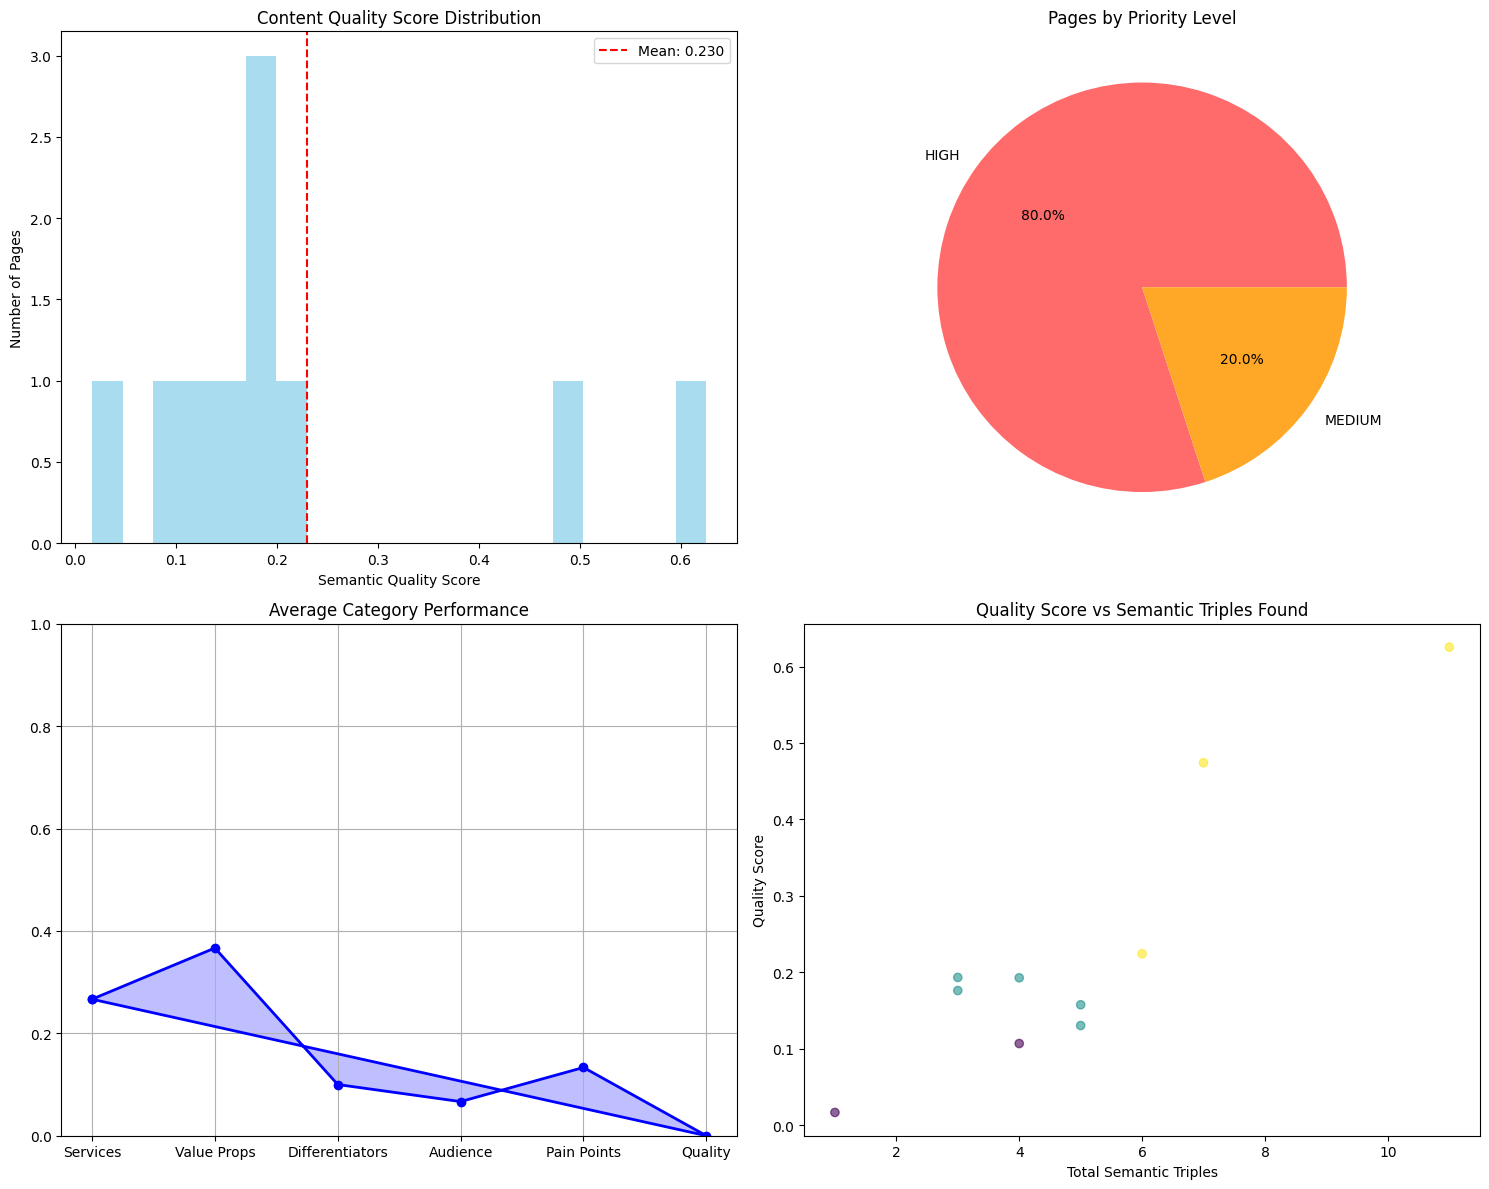

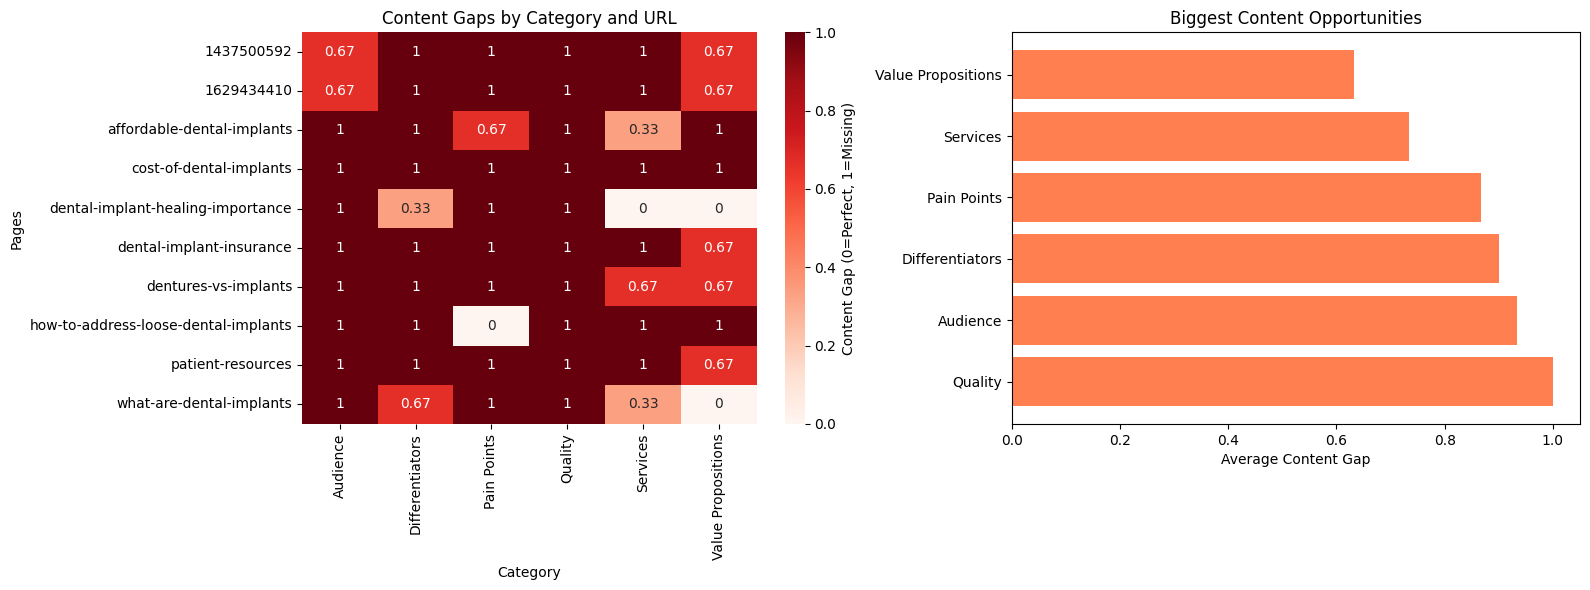

📈 Creating Executive Insights Dashboard


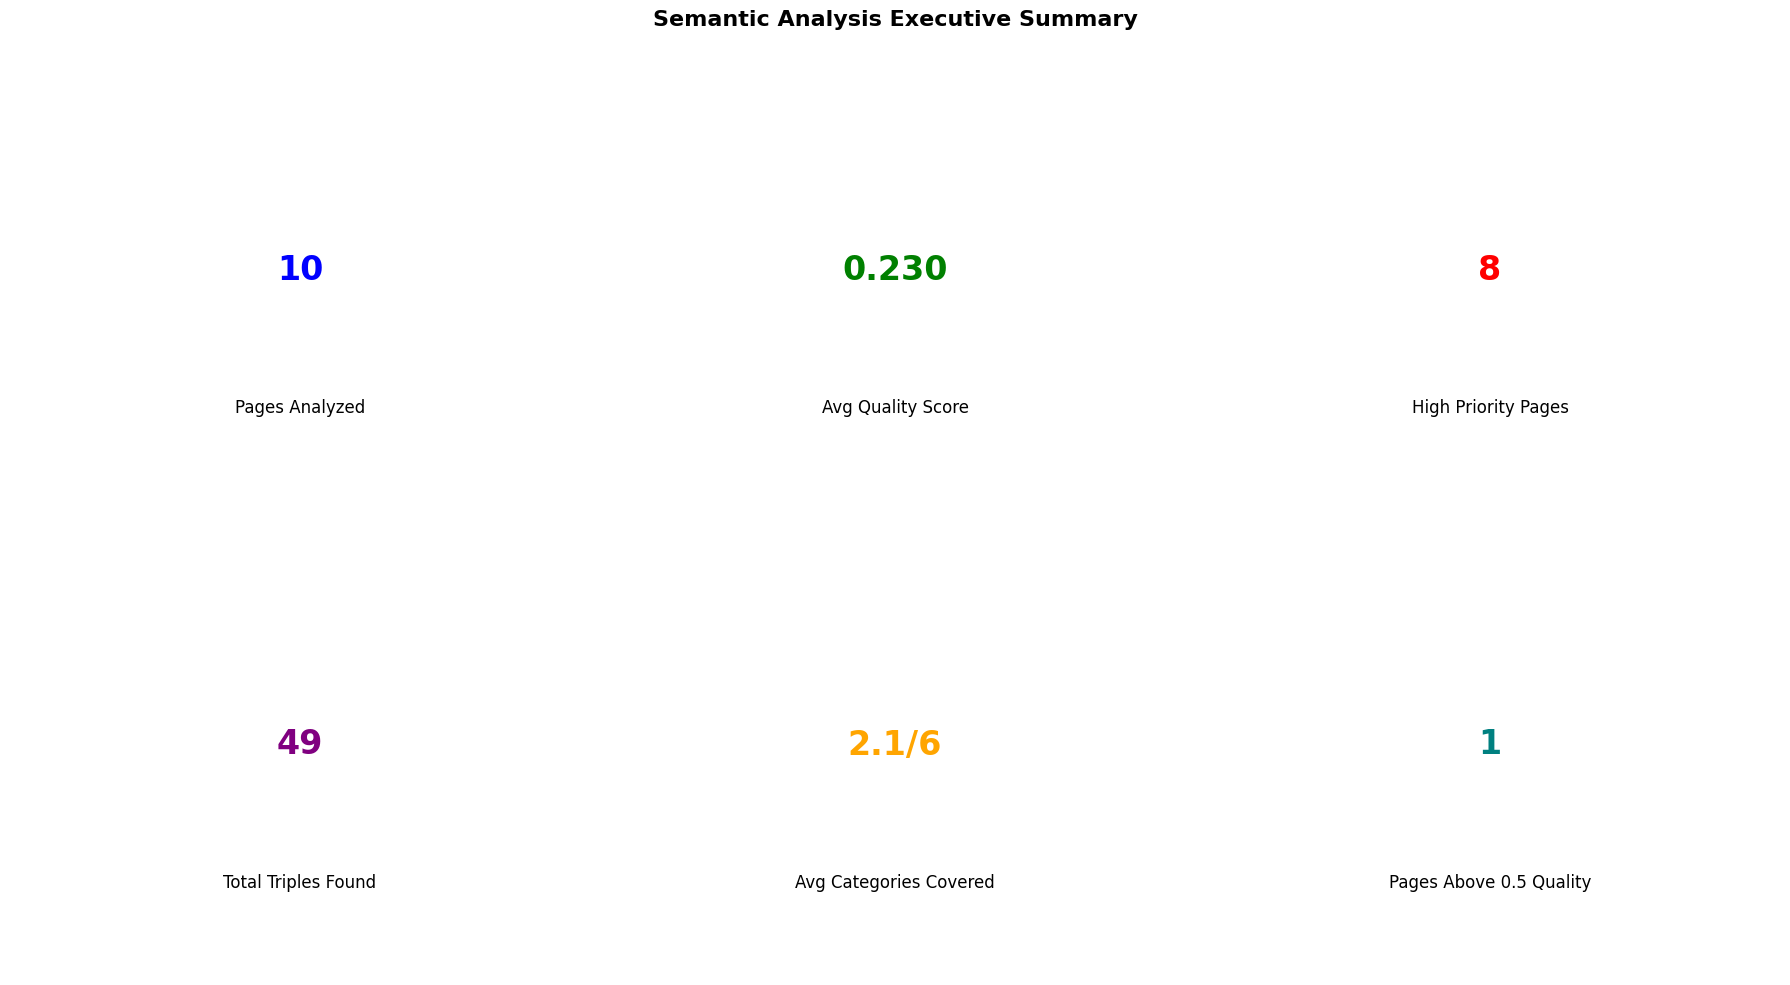

✅ All visualizations created successfully!
📊 Exporting results to /content/drive/MyDrive/Tag/Experiment/semantic_analysis_results.xlsx...
✅ Results exported successfully!
📁 File saved as: /content/drive/MyDrive/Tag/Experiment/semantic_analysis_results.xlsx
📋 Sheets created: Summary Results, Detailed Issues, Semantic Triples, Entity Analysis, Recommendations
📈 Creating executive summary: /content/drive/MyDrive/Tag/Experiment/executive_summary.xlsx
✅ Executive summary created!
📁 File saved as: /content/drive/MyDrive/Tag/Experiment/executive_summary.xlsx
📂 Creating individual URL reports in folder: /content/drive/MyDrive/Tag/Experiment/url_reports
✅ Individual reports created for 10 URLs
📁 Reports saved in folder: /content/drive/MyDrive/Tag/Experiment/url_reports
✅ All results saved to Google Drive: Tag/Experiment
🎉 Complete analysis finished!


In [ ]:
results, results_df, gap_data = run_complete_drive_analysis_fixed(
    'Tag/(testing) CC-TAG URL_Text Extraction.xlsx',
    'Tag/CC_TAG Entity Analysis w. Google NLP.xlsx',
    'Tag/Experiment'
)